In [1]:
# =============================================================================
# CELLULE 1 : SETUP & IMPORTS
# =============================================================================
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.metrics import mean_absolute_error, accuracy_score
from scipy.stats import pearsonr
from tqdm import tqdm

# Vérification du device (GPU fortement recommandé pour Batch Size 64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device actif : {device}")

# Vérification du fichier de données
filename = "aligned_50.pkl"
if not os.path.exists(filename):
    raise FileNotFoundError(f"❌ Le fichier '{filename}' est manquant. Veuillez l'uploader.")
else:
    print(f"✅ Dataset trouvé : {filename}")

✅ Device actif : cpu
✅ Dataset trouvé : aligned_50.pkl


In [2]:
# =============================================================================
# CELLULE 2 : DATASET & GÉNÉRATEURS DE DESCRIPTION (DEVA)
# =============================================================================

# --- A. MAPPINGS (Selon Table 1 & 2 du papier DEVA) ---

# [cite_start]Mapping Audio (Pitch, Loudness, Jitter, Shimmer) [cite: 156]
AUDIO_DESC_MAP = {
    "pitch":    {0: "low pitch",    1: "normal pitch",    2: "high pitch"},
    "loudness": {0: "low loudness", 1: "normal loudness", 2: "high loudness"},
    "jitter":   {0: "low jitter",   1: "normal jitter",   2: "high jitter"},
    "shimmer":  {0: "low shimmer",  1: "normal shimmer",  2: "high shimmer"}
}

# [cite_start]Mapping Visuel (Action Units) [cite: 184]
VISUAL_AU_MAP = {
    0: "raise inner brow", 1: "raise outer brow", 2: "lower brow",
    3: "raise upper lid", 4: "raise cheek", 5: "tighten lid",
    6: "wrinkle nose", 7: "raise upper lip", 8: "pull lip corner",
    9: "depress lip corner", 10: "stretch lip", 11: "tighten lip",
    12: "part lip", 13: "drop jaw", 14: "blink"
}

def audio_description(audio_vec):
    audio_vec = np.nan_to_num(audio_vec)
    chunks = np.array_split(audio_vec, 4)
    features = ["pitch", "loudness", "jitter", "shimmer"]
    selected_levels = []
    
    for i, feature in enumerate(features):
        val = np.mean(chunks[i])
        # Simulation des tertiles
        if val < -0.01: level = 0
        elif val > 0.01: level = 2
        else: level = 1
        selected_levels.append(AUDIO_DESC_MAP[feature][level])
    
    return f"The Speaker made such an tone: {selected_levels[0]}, {selected_levels[1]}, {selected_levels[2]}, and {selected_levels[3]}."

def visual_description(vision_vec, k=3):
    vision_vec = np.nan_to_num(vision_vec)
    top_k_indices = np.argsort(np.abs(vision_vec))[-k:]
    descriptions = [VISUAL_AU_MAP[idx % 15] for idx in top_k_indices]
    return f"The speaker made such an expression: {', '.join(descriptions)}."

# --- B. CLASSE DATASET ---

class LocalMOSIDataset(Dataset):
    def __init__(self, split='train', pkl_path="aligned_50.pkl"):
        with open(pkl_path, "rb") as f:
            full_data = pickle.load(f)
        self.data = full_data[split]
        
        self.vision = self.data['vision']
        self.audio = self.data['audio']
        self.labels = self.data['regression_labels']
        self.text_idxs = np.array(self.data['text_bert'])
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        raw_label = self.labels[idx]
        label = raw_label if np.isscalar(raw_label) else raw_label.item()
            
        aud_vec = np.nan_to_num(np.mean(self.audio[idx], axis=0))
        vis_vec = np.nan_to_num(np.mean(self.vision[idx], axis=0))
        
        txt = self.text_idxs[idx]
        if isinstance(txt, np.ndarray): txt = txt.flatten()
        else: txt = np.array(txt).flatten()
            
        target_len = 50
        if len(txt) > target_len: txt = txt[:target_len]
        else: txt = np.pad(txt, (0, target_len - len(txt)), mode='constant')
        
        return {
            "text_idxs": torch.tensor(txt).long(),
            "audio_vec": torch.tensor(aud_vec).float(),
            "vision_vec": torch.tensor(vis_vec).float(),
            "label": torch.tensor(float(label)).float()
        }

# --- C. DATALOADERS ---
BATCH_SIZE = 64 
train_ds = LocalMOSIDataset('train')
test_ds = LocalMOSIDataset('test')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
print(f"✅ DataLoaders prêts. (Train: {len(train_ds)}, Test: {len(test_ds)})")

✅ DataLoaders prêts. (Train: 1284, Test: 686)


In [3]:
# =============================================================================
# CELLULE 3 : COMPOSANTS ARCHITECTURE DEVA
# =============================================================================

class TextEncoder(nn.Module):
    def __init__(self, d_model=768, T=8):
        super().__init__()
        self.T = T
        self.special_token = nn.Parameter(torch.randn(1, 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, bert_output):
        B = bert_output.size(0)
        E_m_batch = self.special_token.expand(B, -1, -1)
        combined = torch.cat([E_m_batch, bert_output], dim=1)
        out = self.transformer(combined)
        return out[:, :self.T, :] 

class AudioVisualFeatureProjector(nn.Module):
    def __init__(self, d_model=768):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU()
        )
    def forward(self, x): return self.proj(x)

class CrossModalAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, num_heads=4, batch_first=True)
    def forward(self, query, key_value):
        attn_output, _ = self.mha(query, key_value, key_value)
        return attn_output

class MFU(nn.Module):
    def __init__(self, d_model=768):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.attn_t_a = CrossModalAttention(d_model)
        self.attn_t_v = CrossModalAttention(d_model)
        self.alpha = nn.Parameter(torch.tensor(0.01))
        self.beta = nn.Parameter(torch.tensor(0.01))

    def forward(self, Xt, Xa, Xv):
        feat_a = self.attn_t_a(query=Xt, key_value=Xa)
        feat_v = self.attn_t_v(query=Xt, key_value=Xv)
        fused = Xt + (self.alpha * feat_a) + (self.beta * feat_v) # [cite: 213]
        return self.norm(fused)

In [4]:
# =============================================================================
# CELLULE 4 : DÉFINITION DES DEUX MODÈLES
# =============================================================================

# --- MODÈLE 1 : DEVA STANDARD (BERT Base) ---
class DEVANetStandard(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        # [cite_start]Backbone Générique [cite: 56]
        model_name = "bert-base-uncased"
        self.bert = BertModel.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
        # Modules DEVA
        self.text_encoder = TextEncoder(d_model=768, T=8)
        self.av_projector = AudioVisualFeatureProjector(d_model=768)
        self.mfu = MFU(d_model=768)
        
        self.regressor = nn.Sequential(
            nn.Linear(768, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 1)
        )

    def get_bert_emb_from_str(self, text_list):
        inputs = self.tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=25).to(self.device)
        with torch.no_grad():
            return self.bert(**inputs).last_hidden_state

    def forward(self, text_idxs, audio_vecs, vision_vecs):
        if text_idxs.dim() == 3: text_idxs = text_idxs.squeeze(-1)
        with torch.no_grad():
            mask = (text_idxs > 0).long()
            bert_t = self.bert(input_ids=text_idxs, attention_mask=mask).last_hidden_state
        Xt = self.text_encoder(bert_t)
        
        desc_audios = [audio_description(a) for a in audio_vecs.detach().cpu().numpy()]
        desc_visions = [visual_description(v) for v in vision_vecs.detach().cpu().numpy()]
        emb_a = self.get_bert_emb_from_str(desc_audios)
        emb_v = self.get_bert_emb_from_str(desc_visions)
        
        Xa = self.av_projector(self.text_encoder(emb_a))
        Xv = self.av_projector(self.text_encoder(emb_v))
        
        X_fused = self.mfu(Xt, Xa, Xv)
        return self.regressor(X_fused.mean(dim=1))


# --- MODÈLE 2 : DEVA SENTIMENT (BERT Expert SST-2) ---
class DEVANetSentiment(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        
        # Backbone Expert (SST-2)
        model_name = "textattack/bert-base-uncased-SST-2"
        print(f"📥 DEVA charge le backbone expert : {model_name}...")
        self.bert = BertModel.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
        # Reste identique
        self.text_encoder = TextEncoder(d_model=768, T=8)
        self.av_projector = AudioVisualFeatureProjector(d_model=768)
        self.mfu = MFU(d_model=768)
        
        self.regressor = nn.Sequential(
            nn.Linear(768, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 1)
        )

    def get_bert_emb_from_str(self, text_list):
        inputs = self.tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=25).to(self.device)
        with torch.no_grad():
            return self.bert(**inputs).last_hidden_state

    def forward(self, text_idxs, audio_vecs, vision_vecs):
        if text_idxs.dim() == 3: text_idxs = text_idxs.squeeze(-1)
        with torch.no_grad():
            mask = (text_idxs > 0).long()
            bert_t = self.bert(input_ids=text_idxs, attention_mask=mask).last_hidden_state
        Xt = self.text_encoder(bert_t)
        
        desc_audios = [audio_description(a) for a in audio_vecs.detach().cpu().numpy()]
        desc_visions = [visual_description(v) for v in vision_vecs.detach().cpu().numpy()]
        emb_a = self.get_bert_emb_from_str(desc_audios)
        emb_v = self.get_bert_emb_from_str(desc_visions)
        
        Xa = self.av_projector(self.text_encoder(emb_a))
        Xv = self.av_projector(self.text_encoder(emb_v))
        
        X_fused = self.mfu(Xt, Xa, Xv)
        return self.regressor(X_fused.mean(dim=1))

In [5]:
# =============================================================================
# CELLULE 5 : ENTRAÎNEMENT AVEC VALIDATION & COMPARATIVE
# =============================================================================
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np
import copy 

# --- Préparation du DataLoader de Validation ---
print("Chargement du set de Validation...")
valid_ds = LocalMOSIDataset('valid')
# On utilise le même batch size que défini précédemment
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

def evaluate_loop(model, loader):
    """Fonction helper pour passer un dataset complet dans le modèle."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            txt = batch['text_idxs'].to(device)
            aud = batch['audio_vec'].to(device)
            vis = batch['vision_vec'].to(device)
            lbl = batch['label'].to(device)
            
            p = model(txt, aud, vis).squeeze()
            all_preds.extend(p.cpu().tolist() if p.ndim > 0 else [p.item()])
            all_labels.extend(lbl.cpu().tolist())
    return all_labels, all_preds

def evaluate_metrics(y_true, y_pred):
    """Calcule toutes les métriques demandées."""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Régression
    mae = mean_absolute_error(y_true, y_pred)
    corr = pearsonr(y_true, y_pred)[0] if np.var(y_pred) > 0 else 0.0
    
    # Classification Binaire (Seuil 0)
    bin_true = (y_true >= 0).astype(int)
    bin_pred = (y_pred >= 0).astype(int)
    acc2 = accuracy_score(bin_true, bin_pred)
    f1 = f1_score(bin_true, bin_pred, average='weighted')
    
    # Classification Fine
    acc7 = accuracy_score(np.clip(np.round(y_true), -3, 3), np.clip(np.round(y_pred), -3, 3))
    acc5 = accuracy_score(np.clip(np.round(y_true), -2, 2), np.clip(np.round(y_pred), -2, 2))
    
    return {"MAE": mae, "Corr": corr, "Acc-2": acc2, "F1": f1, "Acc-7": acc7, "Acc-5": acc5}

def train_and_evaluate(model_class, name, epochs=10):
    print(f"\n🚀 Démarrage Entraînement : {name}...")
    model = model_class(device).to(device)
    loss_fn = nn.MSELoss()
    
    # Paramètres d'optimisation
    optimizer = optim.AdamW([
        {'params': [p for n, p in model.named_parameters() if "bert" in n], 'lr': 2e-5},
        {'params': [p for n, p in model.named_parameters() if "bert" not in n], 'lr': 1e-4}
    ], weight_decay=0.01)
    
    # Variables pour le checkpointing basé sur la VALIDATION
    best_valid_mae = float('inf')
    
    # On garde une trace pour l'historique (utile pour la cellule 13)
    history = {'train_loss': [], 'valid_metrics': []}
    
    for epoch in range(epochs):
        # 1. TRAIN
        model.train()
        loop = tqdm(train_loader, desc=f"{name} Ep {epoch+1}")
        epoch_loss = 0
        for batch in loop:
            txt, aud, vis, lbl = batch['text_idxs'].to(device), batch['audio_vec'].to(device), batch['vision_vec'].to(device), batch['label'].to(device)
            
            optimizer.zero_grad()
            preds = model(txt, aud, vis).squeeze()
            if preds.ndim == 0: preds = preds.unsqueeze(0)
            loss = loss_fn(preds, lbl)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            loop.set_postfix(loss=f"{loss.item():.4f}")
        
        history['train_loss'].append(epoch_loss / len(train_loader))

        # 2. VALIDATION (Pour choisir le meilleur modèle)
        val_labels, val_preds = evaluate_loop(model, valid_loader)
        val_res = evaluate_metrics(val_labels, val_preds)
        history['valid_metrics'].append(val_res)
        
        # Checkpoint: On sauvegarde si la MAE de Validation est meilleure
        msg = ""
        if val_res['MAE'] < best_valid_mae:
            best_valid_mae = val_res['MAE']
            torch.save(model.state_dict(), f"best_{name}.pth")
            msg = "★ BEST VALID"
            
        print(f"   [Valid] MAE: {val_res['MAE']:.4f} | Acc-2: {val_res['Acc-2']:.4f} {msg}")
        
    # 3. TEST FINAL (Sur le meilleur modèle retenu par la validation)
    print(f"\n📝 Évaluation Finale sur le Test Set (Meilleur modèle validé)...")
    model.load_state_dict(torch.load(f"best_{name}.pth")) # Recharger le meilleur
    
    test_labels, test_preds = evaluate_loop(model, test_loader)
    final_metrics = evaluate_metrics(test_labels, test_preds)
    
    print(f"   >>> TEST RESULT: MAE: {final_metrics['MAE']:.4f} | Acc-2: {final_metrics['Acc-2']:.4f}")
    
    # On renvoie les métriques finales et l'historique pour l'affichage global
    return final_metrics

# --- EXÉCUTION DE LA COMPARAISON ---

# 1. Entraîner DEVA Standard   
print("-" * 60)
results_standard = train_and_evaluate(DEVANetStandard, "DEVA_Standard")

# 2. Entraîner DEVA Sentiment
print("-" * 60)
results_sentiment = train_and_evaluate(DEVANetSentiment, "DEVA_Sentiment")

# 3. Tableau Récapitulatif Final (Sur le Test Set)
print("\n" + "="*80)
print(f"{'MÉTRIQUE (TEST)':<15} | {'DEVA STANDARD':<25} | {'DEVA SENTIMENT':<25}")
print("="*80)
print(f"{'MAE':<15} | {results_standard['MAE']:<25.4f} | {results_sentiment['MAE']:<25.4f}")
print(f"{'Corr':<15} | {results_standard['Corr']:<25.4f} | {results_sentiment['Corr']:<25.4f}")
print(f"{'Acc-2':<15} | {results_standard['Acc-2']:<25.4f} | {results_sentiment['Acc-2']:<25.4f}")
print(f"{'F1':<15} | {results_standard['F1']:<25.4f} | {results_sentiment['F1']:<25.4f}")
print(f"{'Acc-5':<15} | {results_standard['Acc-5']:<25.4f} | {results_sentiment['Acc-5']:<25.4f}")
print(f"{'Acc-7':<15} | {results_standard['Acc-7']:<25.4f} | {results_sentiment['Acc-7']:<25.4f}")
print("-" * 80)

# Conclusion automatique
delta_mae = results_standard['MAE'] - results_sentiment['MAE']
if delta_mae > 0:
    print(f"✅ GAGNANT : DEVA SENTIMENT (Amélioration MAE: {delta_mae:.4f})")
else:
    print(f"⚠️ GAGNANT : DEVA STANDARD")
print("="*80)

Chargement du set de Validation...
------------------------------------------------------------

🚀 Démarrage Entraînement : DEVA_Standard...
------------------------------------------------------------

🚀 Démarrage Entraînement : DEVA_Standard...


DEVA_Standard Ep 1: 100%|██████████| 21/21 [01:45<00:00,  5.02s/it, loss=2.3950]



   [Valid] MAE: 1.1756 | Acc-2: 0.6987 ★ BEST VALID


DEVA_Standard Ep 2: 100%|██████████| 21/21 [01:42<00:00,  4.86s/it, loss=3.0031]



   [Valid] MAE: 1.0176 | Acc-2: 0.7598 ★ BEST VALID


DEVA_Standard Ep 3: 100%|██████████| 21/21 [01:42<00:00,  4.89s/it, loss=0.5719]



   [Valid] MAE: 1.0437 | Acc-2: 0.7467 


DEVA_Standard Ep 4: 100%|██████████| 21/21 [01:40<00:00,  4.77s/it, loss=2.0418]



   [Valid] MAE: 0.9505 | Acc-2: 0.7817 ★ BEST VALID


DEVA_Standard Ep 5: 100%|██████████| 21/21 [01:42<00:00,  4.86s/it, loss=0.6853]



   [Valid] MAE: 0.9298 | Acc-2: 0.8079 ★ BEST VALID


DEVA_Standard Ep 6: 100%|██████████| 21/21 [24:08<00:00, 68.98s/it, loss=1.4110]  



   [Valid] MAE: 0.9210 | Acc-2: 0.7860 ★ BEST VALID


DEVA_Standard Ep 7: 100%|██████████| 21/21 [04:14<00:00, 12.12s/it, loss=0.4957]



   [Valid] MAE: 0.9399 | Acc-2: 0.7904 


DEVA_Standard Ep 8: 100%|██████████| 21/21 [03:37<00:00, 10.37s/it, loss=0.7061]



   [Valid] MAE: 0.9039 | Acc-2: 0.8166 ★ BEST VALID


DEVA_Standard Ep 9: 100%|██████████| 21/21 [05:36<00:00, 16.02s/it, loss=0.4842]



   [Valid] MAE: 0.9895 | Acc-2: 0.7642 


DEVA_Standard Ep 10: 100%|██████████| 21/21 [04:56<00:00, 14.11s/it, loss=1.4947]



   [Valid] MAE: 0.9632 | Acc-2: 0.7860 

📝 Évaluation Finale sur le Test Set (Meilleur modèle validé)...
   >>> TEST RESULT: MAE: 0.9262 | Acc-2: 0.7741
------------------------------------------------------------

🚀 Démarrage Entraînement : DEVA_Sentiment...
📥 DEVA charge le backbone expert : textattack/bert-base-uncased-SST-2...
   >>> TEST RESULT: MAE: 0.9262 | Acc-2: 0.7741
------------------------------------------------------------

🚀 Démarrage Entraînement : DEVA_Sentiment...
📥 DEVA charge le backbone expert : textattack/bert-base-uncased-SST-2...


DEVA_Sentiment Ep 1: 100%|██████████| 21/21 [03:53<00:00, 11.12s/it, loss=0.3182]



   [Valid] MAE: 0.7646 | Acc-2: 0.8341 ★ BEST VALID


DEVA_Sentiment Ep 2: 100%|██████████| 21/21 [04:00<00:00, 11.46s/it, loss=0.2381]



   [Valid] MAE: 0.7651 | Acc-2: 0.8559 


DEVA_Sentiment Ep 3: 100%|██████████| 21/21 [04:45<00:00, 13.59s/it, loss=0.6133]



   [Valid] MAE: 0.7663 | Acc-2: 0.8297 


DEVA_Sentiment Ep 4: 100%|██████████| 21/21 [05:27<00:00, 15.61s/it, loss=0.1840]



   [Valid] MAE: 0.7466 | Acc-2: 0.8341 ★ BEST VALID


DEVA_Sentiment Ep 5: 100%|██████████| 21/21 [05:28<00:00, 15.63s/it, loss=0.2408]



   [Valid] MAE: 0.7503 | Acc-2: 0.8384 


DEVA_Sentiment Ep 6: 100%|██████████| 21/21 [06:06<00:00, 17.47s/it, loss=0.1367]



   [Valid] MAE: 0.7386 | Acc-2: 0.8341 ★ BEST VALID


DEVA_Sentiment Ep 7: 100%|██████████| 21/21 [05:59<00:00, 17.11s/it, loss=1.2360]



   [Valid] MAE: 0.7329 | Acc-2: 0.8559 ★ BEST VALID


DEVA_Sentiment Ep 8: 100%|██████████| 21/21 [01:45<00:00,  5.04s/it, loss=0.0968]



   [Valid] MAE: 0.7921 | Acc-2: 0.8253 


DEVA_Sentiment Ep 9: 100%|██████████| 21/21 [02:47<00:00,  7.98s/it, loss=0.4123]



   [Valid] MAE: 0.7253 | Acc-2: 0.8472 ★ BEST VALID


DEVA_Sentiment Ep 10: 100%|██████████| 21/21 [02:48<00:00,  8.04s/it, loss=0.0553]



   [Valid] MAE: 0.7406 | Acc-2: 0.8472 

📝 Évaluation Finale sur le Test Set (Meilleur modèle validé)...
   >>> TEST RESULT: MAE: 0.7358 | Acc-2: 0.8222

MÉTRIQUE (TEST) | DEVA STANDARD             | DEVA SENTIMENT           
MAE             | 0.9262                    | 0.7358                   
Corr            | 0.6866                    | 0.7931                   
Acc-2           | 0.7741                    | 0.8222                   
F1              | 0.7740                    | 0.8211                   
Acc-5           | 0.3732                    | 0.5219                   
Acc-7           | 0.3382                    | 0.4461                   
--------------------------------------------------------------------------------
✅ GAGNANT : DEVA SENTIMENT (Amélioration MAE: 0.1904)
   >>> TEST RESULT: MAE: 0.7358 | Acc-2: 0.8222

MÉTRIQUE (TEST) | DEVA STANDARD             | DEVA SENTIMENT           
MAE             | 0.9262                    | 0.7358                   
Corr          


COMPARAISON FINALE: BERT STANDARD vs BERT AMÉLIORÉ (SENTIMENT)

MÉTRIQUE             | BERT STANDARD             | BERT SENTIMENT            | Δ (Amélioration)    
------------------------------------------------------------------------------------------
MAE                  | 0.9262                    | 0.7358                    | +0.1904             
Corr                 | 0.6866                    | 0.7931                    | +0.1065             
Acc-2                | 77.41                   % | 82.22                   % | +4.81%              
F1                   | 77.40                   % | 82.11                   % | +4.71%              
Acc-5                | 37.32                   % | 52.19                   % | +14.87%             
Acc-7                | 33.82                   % | 44.61                   % | +10.79%             

✅ GAGNANT: BERT AMÉLIORÉ (SENTIMENT)
   → Amélioration MAE: 0.1904

✓ Résultats sauvegardés (JSON): results_comparison\comparison_20251201_1528

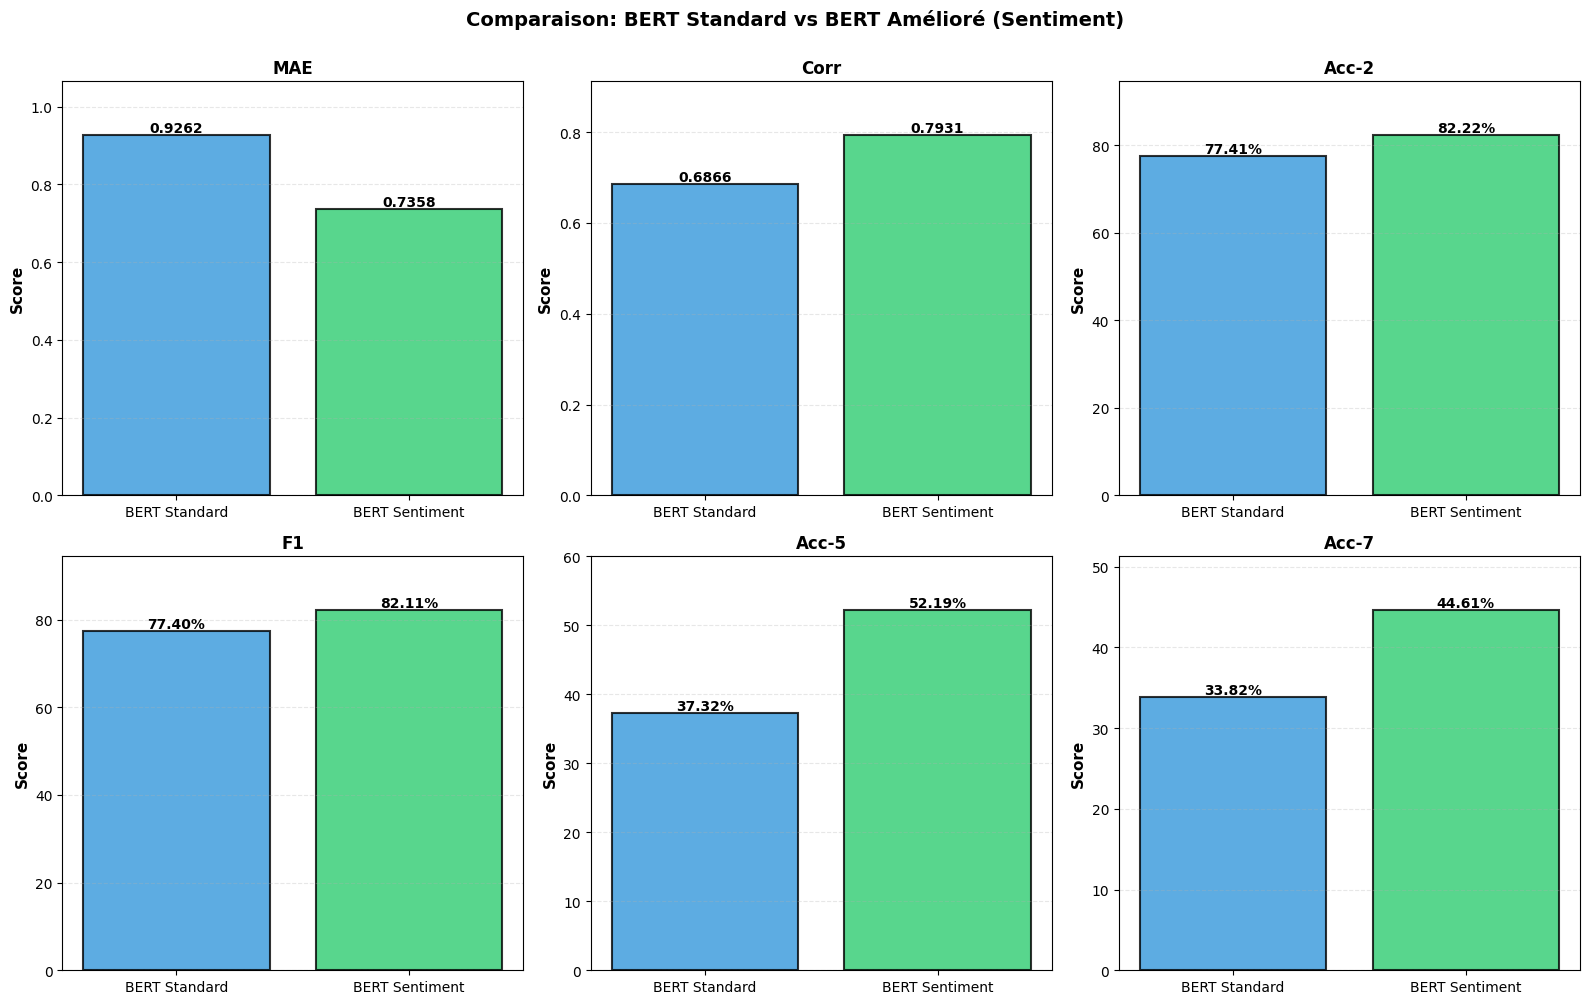


FICHIERS SAUVEGARDÉS:
  📄 JSON:  results_comparison\comparison_20251201_152826.json
  📋 TXT:   results_comparison\comparison_20251201_152826.txt
  📊 PNG:   results_comparison\comparison_20251201_152826.png


In [10]:
# ==============================================================================
# CELL 6: Visualisation et Sauvegarde des Résultats (BERT Standard vs BERT Sentiment)
# ==============================================================================

import os
from datetime import datetime
import json
import matplotlib.pyplot as plt

# Créer le dossier de sauvegarde
SAVE_DIR = 'results_comparison'
os.makedirs(SAVE_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Vérifier que les deux résultats existent
if 'results_standard' not in globals() or 'results_sentiment' not in globals():
    print("❌ Erreur: les variables results_standard et results_sentiment ne sont pas définies.")
    print("Assurez-vous d'avoir exécuté l'entraînement (cellule 5) avant cette cellule.")
else:
    results_standard = globals()['results_standard']
    results_sentiment = globals()['results_sentiment']
    
    # ---------------------------
    # 1. Tableau Récapitulatif Comparatif (Console)
    # ---------------------------
    print("\n" + "="*90)
    print("COMPARAISON FINALE: BERT STANDARD vs BERT AMÉLIORÉ (SENTIMENT)")
    print("="*90)
    print(f"\n{'MÉTRIQUE':<20} | {'BERT STANDARD':<25} | {'BERT SENTIMENT':<25} | {'Δ (Amélioration)':<20}")
    print("-"*90)
    
    metrics_list = ['MAE', 'Corr', 'Acc-2', 'F1', 'Acc-5', 'Acc-7']
    for metric in metrics_list:
        std_val = results_standard.get(metric, 0)
        sent_val = results_sentiment.get(metric, 0)
        
        # Pour MAE et Corr, les unités ne sont pas des % 
        if metric in ['MAE']:
            delta = std_val - sent_val  # Pour MAE, moins c'est mieux
            delta_str = f"{delta:+.4f}"
            print(f"{metric:<20} | {std_val:<25.4f} | {sent_val:<25.4f} | {delta_str:<20}")
        elif metric in ['Corr']:
            delta = sent_val - std_val
            delta_str = f"{delta:+.4f}"
            print(f"{metric:<20} | {std_val:<25.4f} | {sent_val:<25.4f} | {delta_str:<20}")
        else:
            # Pour les accuracies et F1 (exprimer en %)
            std_pct = std_val * 100 if std_val <= 1 else std_val
            sent_pct = sent_val * 100 if sent_val <= 1 else sent_val
            delta_pct = sent_pct - std_pct
            delta_str = f"{delta_pct:+.2f}%"
            print(f"{metric:<20} | {std_pct:<24.2f}% | {sent_pct:<24.2f}% | {delta_str:<20}")
    
    print("="*90)
    
    # Conclusion
    mae_improvement = results_standard['MAE'] - results_sentiment['MAE']
    if mae_improvement > 0:
        print(f"\n✅ GAGNANT: BERT AMÉLIORÉ (SENTIMENT)")
        print(f"   → Amélioration MAE: {mae_improvement:.4f}")
    else:
        print(f"\n⚠️ GAGNANT: BERT STANDARD")
        print(f"   → Perte MAE: {-mae_improvement:.4f}")
    print("="*90)
    
    # ---------------------------
    # 2. Sauvegarder les résultats en JSON (pour analyses ultérieures)
    # ---------------------------
    comparison_dict = {
        "timestamp": timestamp,
        "models": {
            "BERT_STANDARD": {
                "name": "bert-base-uncased",
                "metrics": results_standard
            },
            "BERT_SENTIMENT": {
                "name": "textattack/bert-base-uncased-SST-2",
                "metrics": results_sentiment
            }
        },
        "improvement": {
            "MAE_delta": mae_improvement,
            "winner": "BERT_SENTIMENT" if mae_improvement > 0 else "BERT_STANDARD"
        }
    }
    
    json_path = os.path.join(SAVE_DIR, f"comparison_{timestamp}.json")
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(comparison_dict, f, indent=4)
    print(f"\n✓ Résultats sauvegardés (JSON): {json_path}")
    
    # ---------------------------
    # 3. Sauvegarder les résultats en TXT (rapport lisible)
    # ---------------------------
    txt_path = os.path.join(SAVE_DIR, f"comparison_{timestamp}.txt")
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("RAPPORT DE COMPARAISON: BERT STANDARD vs BERT AMÉLIORÉ\n")
        f.write("="*80 + "\n\n")
        f.write(f"Date: {timestamp}\n\n")
        
        f.write("MODÈLE 1: BERT STANDARD\n")
        f.write("-"*40 + "\n")
        f.write(f"Backbone: bert-base-uncased\n")
        f.write(f"Métriques:\n")
        for metric in metrics_list:
            val = results_standard.get(metric, 0)
            if metric in ['MAE', 'Corr']:
                f.write(f"  {metric}: {val:.4f}\n")
            else:
                pct = val * 100 if val <= 1 else val
                f.write(f"  {metric}: {pct:.2f}%\n")
        
        f.write("\n")
        f.write("MODÈLE 2: BERT AMÉLIORÉ (SENTIMENT)\n")
        f.write("-"*40 + "\n")
        f.write(f"Backbone: textattack/bert-base-uncased-SST-2\n")
        f.write(f"Métriques:\n")
        for metric in metrics_list:
            val = results_sentiment.get(metric, 0)
            if metric in ['MAE', 'Corr']:
                f.write(f"  {metric}: {val:.4f}\n")
            else:
                pct = val * 100 if val <= 1 else val
                f.write(f"  {metric}: {pct:.2f}%\n")
        
        f.write("\n")
        f.write("ANALYSE COMPARATIVE\n")
        f.write("-"*40 + "\n")
        for metric in metrics_list:
            std_val = results_standard.get(metric, 0)
            sent_val = results_sentiment.get(metric, 0)
            
            if metric in ['MAE']:
                delta = std_val - sent_val
                direction = "✓ Amélioré" if delta > 0 else "✗ Dégradé"
                f.write(f"{metric}: {delta:+.4f} ({direction})\n")
            elif metric in ['Corr']:
                delta = sent_val - std_val
                direction = "✓ Amélioré" if delta > 0 else "✗ Dégradé"
                f.write(f"{metric}: {delta:+.4f} ({direction})\n")
            else:
                std_pct = std_val * 100 if std_val <= 1 else std_val
                sent_pct = sent_val * 100 if sent_val <= 1 else sent_val
                delta_pct = sent_pct - std_pct
                direction = "✓ Amélioré" if delta_pct > 0 else "✗ Dégradé"
                f.write(f"{metric}: {delta_pct:+.2f}% ({direction})\n")
        
        f.write("\n")
        f.write("CONCLUSION\n")
        f.write("-"*40 + "\n")
        if mae_improvement > 0:
            f.write(f"🏆 GAGNANT: BERT AMÉLIORÉ (SENTIMENT)\n")
            f.write(f"Amélioration MAE: {mae_improvement:.4f}\n")
        else:
            f.write(f"🏆 GAGNANT: BERT STANDARD\n")
            f.write(f"Perte MAE: {-mae_improvement:.4f}\n")
    
    print(f"✓ Rapport sauvegardé (TXT): {txt_path}")
    
    # ---------------------------
    # 4. Créer un graphique de comparaison
    # ---------------------------
    try:
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        
        # Métriques à afficher
        plot_metrics = ['MAE', 'Corr', 'Acc-2', 'F1', 'Acc-5', 'Acc-7']
        
        for idx, metric in enumerate(plot_metrics):
            ax = axes[idx // 3, idx % 3]
            
            std_val = results_standard.get(metric, 0)
            sent_val = results_sentiment.get(metric, 0)
            
            # Convertir en % si nécessaire (sauf MAE et Corr)
            if metric not in ['MAE', 'Corr']:
                std_val = std_val * 100 if std_val <= 1 else std_val
                sent_val = sent_val * 100 if sent_val <= 1 else sent_val
            
            bars = ax.bar(['BERT Standard', 'BERT Sentiment'], [std_val, sent_val], 
                          color=['#3498db', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=1.5)
            
            # Ajouter les valeurs sur les barres
            for bar in bars:
                height = bar.get_height()
                if metric not in ['MAE', 'Corr']:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
                else:
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            ax.set_ylabel('Score', fontsize=11, fontweight='bold')
            ax.set_title(metric, fontsize=12, fontweight='bold')
            ax.set_ylim(0, max(std_val, sent_val) * 1.15)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.suptitle('Comparaison: BERT Standard vs BERT Amélioré (Sentiment)', 
                     fontsize=14, fontweight='bold', y=1.00)
        plt.tight_layout()
        
        fig_path = os.path.join(SAVE_DIR, f"comparison_{timestamp}.png")
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        print(f"✓ Graphique sauvegardé: {fig_path}")
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Erreur lors de la création du graphique: {e}")
    
    # ---------------------------
    # 5. Résumé final
    # ---------------------------
    print("\n" + "="*90)
    print("FICHIERS SAUVEGARDÉS:")
    print(f"  📄 JSON:  {json_path}")
    print(f"  📋 TXT:   {txt_path}")
    print(f"  📊 PNG:   {fig_path}")
    print("="*90)
